In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [122]:
class N_Armed_Bandit():
    
    def __init__(self, game, play, n_arms, control_paras,
                 whether_stationary = 1,
                 initial_addup = 0,
                 burning_period=1,
                 step_size = None,
                 selection_method='softmax',
                 incre_implem=0):
        
        # times of game
        self.game = game
        
        # times of playround during each game
        self.play = play
        
        # how many levers
        self.n_arms = n_arms
        
        # epsilon for epsilon-greedy, tau(tempreture) for softmax
        self.control_paras = control_paras
        
        # how many rounds of burning period are included during the simulation
        self.burning_period = burning_period
        
        # n_unique of control_paras decisdes how many methods are competing
        self.n_group = len(control_paras)
        
        # which method to select action
        self.selection_method = selection_method
        
        # whether use incremental implementation
        self.incre_implem = incre_implem
        
        # whether the state goes stationary, if None, means this is a stationary problem
        self.step_size = step_size
        
        # whether addup some figures on initial zeros
        self.initial_addup = initial_addup
        
        # whether the problem is stationary or nonstationary
        self.whether_stationary = whether_stationary
           
    def __DataRestoration(self):
        
        # True rewards, fixed for each game
        self.true_rwd = np.random.normal(0,1,self.n_arms)
        self.best_action = np.argmax(self.true_rwd)
        
        # Estimated reward, update after each play
        self.estimated_rwd = np.zeros((self.n_group,self.n_arms))+self.initial_addup
        
        # Record total reward of each action, update after each play
        self.acc_action_rwd = np.zeros((self.n_group,self.n_arms))           
        
        # Track the times each action taken, used for update estimated reward when incre_implem=0, 
        # and for calculate optimal_choice%
        self.action_times = np.zeros((self.n_group,self.n_arms))
        
        # Track the action taking at current playround (for gradient method)
        self.current_action = None
        
        # Track the optimal action taken percentage in each playround
        self.optimal_taken_percentage = np.zeros((self.n_group,self.play))

        # Track the accumulated reward during the play
        self.acc_rwd_track = np.zeros((self.n_group,self.play))   
        
        # Track the greedy action reward in each playround
        self.greedy_action_rwd_track = np.zeros((self.n_group,self.play))
    
        # Track the Nonstationary Reward change in each playround
        self.nonstationary_rwd_track = np.zeros((self.play,self.n_arms))
        
        # Used for updating preferences in Gradient Method
        self.gradient_preferences = np.zeros((self.n_group,self.n_arms))
        
        # Used for updating probabilities in Gradient Method
        self.gradient_prob = np.array([[1/self.n_arms for i in range(self.n_arms)] for j in range(self.n_group)])
        
        # Mark the current rewards for current playround, used for Gradient method
        self.current_reward_list=[-1000 for i in range(self.n_group)]
        
    # Similar to MCMC to generate nonstationary tasks
    def __Nonstationary(self):
        
        last_true_rwd = list(self.true_rwd)
        scales = [1 for i in range(self.n_arms)]
        self.true_rwd = np.random.normal(loc=last_true_rwd,
                                         scale=scales)
        self.best_action = np.argmax(self.true_rwd)
            
    def Track_Nonatationary(self,p):
        
        self.nonstationary_rwd_track[p,:] = self.true_rwd
        
    def Softmax_selection(self,Q_t):
        
        # reshape paras, to adapt numpy array computation
        tau = np.array(self.control_paras).reshape(self.n_group,-1)
        
        numerator = np.exp(Q_t/tau)
        denominator = numerator.sum(axis=1,keepdims=True)
        softmax_prob = numerator/denominator
        
        a=[]
        exploiting=[]  
        
        for i in range(self.n_group):
                    
            a_temp = np.random.choice(list(range(self.n_arms)),p=softmax_prob[i,:])
            
            # this code equals to find the action with largest estimated reward
            exploiting_temp = int(np.argmax(softmax_prob[i,:]))
            
            a.append(a_temp)
            exploiting.append(exploiting_temp)
            
        return a,exploiting
     
    def Epsilon_greedy_selection(self,Q_t):

        greedy_prob = np.random.uniform(0,1)
        a = []
        exploiting = []
        
        for i in range(self.n_group):

            if self.control_paras[i]==0:
                a_temp = int(np.argmax(self.estimated_rwd[i,:]))
                exploiting_temp = a_temp
                a.append(a_temp)
                exploiting.append(exploiting_temp)
            else:
                exploring = list(range(self.n_arms))
                exploiting_temp = np.argmax(self.estimated_rwd[i,:])
                exploring.remove(exploiting_temp)
                a_temp = int((greedy_prob<=self.control_paras[i])*np.random.choice(exploring))+int((greedy_prob>self.control_paras[i])*exploiting_temp)
                a.append(a_temp)
                exploiting.append(exploiting_temp)
                
        return a,exploiting
    
    def UCB(self,Q_t,p):
        
        a = []
        exploiting = []
        
        for i in range(self.n_group):
            
            if 0 in self.action_times[i,:]:
                choices = np.where(self.action_times[i,:]==0)[0]
                a_temp = np.random.choice(choices)
                exploiting_temp = np.argmax(Q_t[i,:])
            else:
                a_temp = np.argmax(Q_t[i,:]+self.control_paras[i]*np.sqrt(np.log(p)/self.action_times[i,:]))
                exploiting_temp = np.argmax(Q_t[i,:])
            
            a.append(a_temp)
            exploiting.append(exploiting_temp)
            
        return a, exploiting
    
    def GradientAscent(self,Q_t,p):
        
        a = []
        exploiting = []
        
        for i in range(self.n_group):
            
            lr = self.control_paras[i]
            avg_R = self.acc_action_rwd[i,:].sum()/p
            R_t = self.current_reward_list[i]
            taken = self.current_action[i]
            not_taken = [i for i in range(self.n_arms)]
            not_taken.remove(taken)
            pi_taken = self.gradient_prob[i,taken]
            pi_not_taken = self.gradient_prob[i,not_taken]
            
            self.gradient_preferences[i,taken] = self.gradient_preferences[i,taken]+lr*(R_t-avg_R)*(1-pi_taken)
            self.gradient_preferences[i,not_taken] = self.gradient_preferences[i,not_taken]-lr*(R_t-avg_R)*pi_not_taken
            
            denominator = np.exp(self.gradient_preferences[i,:]).sum()
            self.gradient_prob[i,:] = np.exp(self.gradient_preferences[i,:])/denominator
            
            a_temp = np.random.choice(list(range(self.n_arms)),p=self.gradient_prob[i,:])
            exploiting_temp = np.argmax(Q_t[i,:])
            
            a.append(a_temp)
            exploiting.append(exploiting_temp)
            
        return a, exploiting
              
    def Choose_action(self,p):
        
        # Strategy During Burning Period
        if p < self.burning_period:
            
            a = np.random.randint(0,self.n_arms,self.n_group)
            exploiting = a
            
        # Strategy After Burning Period
        else:
            
            # Softmax Action Selection
            # ------------------------
            if self.selection_method=='softmax':
                
                a,exploiting = self.Softmax_selection(self.estimated_rwd)
                
            # Epsilon-Greedy Strategy 
            # ------------------------
            if self.selection_method=='epsilon':
                
                a,exploiting = self.Epsilon_greedy_selection(self.estimated_rwd)
                
            # Uppeer-Bound-Confidence Selection
            # ---------------------------------
            if self.selection_method=='UCB':
                
                a,exploiting = self.UCB(self.estimated_rwd,p)
                
            # Gradient Ascent Selection
            # ---------------------------------               
            if self.selection_method=='Gradient':
                
                a,exploiting = self.GradientAscent(self.estimated_rwd,p)
                
        self.current_action = a
                
        return a,exploiting
    
    def Update_Rewards(self,a,p,exploiting):
        
        for i in range(self.n_group):

            # update action times taken
            self.action_times[i,a[i]] += 1
            
            current_reward = np.random.normal(self.true_rwd[a[i]],1)
            self.current_reward_list[i] = current_reward
            
            if self.incre_implem==0:
                # update accumulated rewards of each action
                self.acc_action_rwd[i,a[i]] += current_reward

                # update estimated reward of each action
                self.estimated_rwd[i,a[i]] = self.acc_action_rwd[i,a[i]]/self.action_times[i,a[i]]
                
            if self.incre_implem==1:
                
                self.acc_action_rwd[i,a[i]] += current_reward
                
                if self.step_size == None:
                    self.estimated_rwd[i,a[i]] = self.estimated_rwd[i,a[i]] + (current_reward-self.estimated_rwd[i,a[i]])/(1+self.action_times[i,a[i]])
                else:
                    self.estimated_rwd[i,a[i]] = self.estimated_rwd[i,a[i]] + self.step_size*(current_reward-self.estimated_rwd[i,a[i]])
                
        # record the accumulated reward
        self.acc_rwd_track[:,p] = self.acc_action_rwd.sum(axis=1)/(p+1)
        
    def Track_Greedy(self,a,p,exploiting):
        
        for i in range(self.n_group):
            
            if p==0:
                # update optimal action reward
                self.greedy_action_rwd_track[i,p] = np.random.normal(self.true_rwd[exploiting[i]],1)
            else:
                self.greedy_action_rwd_track[i,p] = (p*(self.greedy_action_rwd_track[i,p-1])+np.random.normal(self.true_rwd[exploiting[i]],1))/(p+1) 
                
    def Track_Optimal(self,p):
        
        for i in range(self.n_group):
            
            self.optimal_taken_percentage[i,p] = self.action_times[i,self.best_action]/(p+1)
    
    def ReadyPlayer(self):
        
        # Track the accumulated reward after each game
        self.total_game_rwd_track = np.zeros((self.n_group,self.play))  
        
        # Track the accumulated reward after each game
        self.total_greedy_action_rwd_track = np.zeros((self.n_group,self.play)) 
        
        # Track the accumulated best action taken percentage after each game
        self.total_optimal_taken_percentage = np.zeros((self.n_group,self.play)) 
        
        # Track the accumulated nonstationary true reward
        self.total_nonstationary_true_rwd = np.zeros((self.play,self.n_arms))
        
        for g in range(self.game):
            
            start = time.time()
            
            # each game need new data restoration
            self.__DataRestoration()
            
            for p in range(self.play):
                
                if self.whether_stationary==0 and p>=1:
                    self.__Nonstationary()                   
                    
                a,exploiting = self.Choose_action(p)
                self.Update_Rewards(a,p,exploiting)
                self.Track_Greedy(a,p,exploiting)
                self.Track_Optimal(p)
                self.Track_Nonatationary(p)
                
            self.total_game_rwd_track += self.acc_rwd_track  
            self.total_greedy_action_rwd_track += self.greedy_action_rwd_track
            self.total_optimal_taken_percentage += self.optimal_taken_percentage
            self.total_nonstationary_true_rwd += self.nonstationary_rwd_track
            
            end = time.time()
            print('game{} finished, time cost {}seconds'.format(g,np.round(end-start,4)))
            
        self.total_game_rwd_track = self.total_game_rwd_track/self.game
        self.total_greedy_action_rwd_track = self.total_greedy_action_rwd_track/self.game
        self.total_optimal_taken_percentage = self.total_optimal_taken_percentage/self.game
        self.total_nonstationary_true_rwd = self.total_nonstationary_true_rwd/self.game
        
        self.reward_data = pd.DataFrame(self.total_game_rwd_track[:,self.burning_period:]).T
        self.greedy_action = pd.DataFrame(self.total_greedy_action_rwd_track[:,self.burning_period:]).T
        self.optimal_taken = pd.DataFrame(self.total_optimal_taken_percentage[:,self.burning_period:]).T
        self.nonstationary_track = pd.DataFrame(self.total_nonstationary_true_rwd)
        
        if self.selection_method=='softmax':
            self.reward_data.columns = ['tau='+str(i) for i in self.control_paras]
            self.greedy_action.columns = ['tau='+str(i) for i in self.control_paras]
            self.optimal_taken.columns = ['tau='+str(i) for i in self.control_paras]
            
        if self.selection_method=='epsilon':
            self.reward_data.columns = ['epsilon='+str(i) for i in self.control_paras]
            self.greedy_action.columns = ['epsilon='+str(i) for i in self.control_paras]
            self.optimal_taken.columns = ['epsilon='+str(i) for i in self.control_paras]
            
        if self.selection_method=='UCB':
            self.reward_data.columns = ['c='+str(i) for i in self.control_paras]
            self.greedy_action.columns = ['c='+str(i) for i in self.control_paras]
            self.optimal_taken.columns = ['c='+str(i) for i in self.control_paras]
            
        if self.selection_method=='Gradient':
            self.reward_data.columns = ['learning_rate='+str(i) for i in self.control_paras]
            self.greedy_action.columns = ['learning_rate='+str(i) for i in self.control_paras]
            self.optimal_taken.columns = ['learning_rate='+str(i) for i in self.control_paras]

**Stationary Situation**

In [73]:
# Epsilon-Greedy Strategy
RP1 = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                     control_paras=[0,0.01,0.1,0.3,0.5],
                     whether_stationary=1,
                     initial_addup=0,
                     burning_period=1,
                     selection_method='epsilon',incre_implem=1)
# Softmax Strategy
RP2 = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                     control_paras=[0.1,0.2,0.5,1,2],
                     whether_stationary=1,
                     initial_addup=0,
                     burning_period=1,
                     selection_method='softmax',incre_implem=1)

# Upper-Bound-Confidence Strategy
RP3 = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                     control_paras=[0.01,0.1,0.5,1,2],
                     whether_stationary=1,
                     initial_addup=0,
                     burning_period=1,
                     selection_method='UCB',incre_implem=1)
# Gradient Bandit
RP4 = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                     control_paras=[0.01,0.03,0.1,0.2,0.3],
                     whether_stationary=1,
                     initial_addup=0,
                     burning_period=1,
                     selection_method='Gradient',incre_implem=1)

**With Baseline**

In [74]:
# Epsilon-Greedy Strategy
RP1_B = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                       control_paras=[0,0.01,0.1,0.3,0.5],
                       whether_stationary=1,
                       initial_addup=4,
                       burning_period=1,
                       selection_method='epsilon',incre_implem=1)

# Softmax Strategy
RP2_B = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                       control_paras=[0.1,0.2,0.5,1,2],
                       whether_stationary=1,
                       initial_addup=4,
                       burning_period=1,
                       selection_method='softmax',incre_implem=1)

# Upper-Bound-Confidence Strategy
RP3_B = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                       control_paras=[0.01,0.1,0.5,1,2],
                       whether_stationary=1,
                       initial_addup=4,
                       burning_period=1,
                       selection_method='UCB',incre_implem=1)
# Gradient Bandit
RP4_B = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                       control_paras=[0.01,0.03,0.1,0.2,0.3],
                       whether_stationary=1,
                       initial_addup=4,
                       burning_period=1,
                       selection_method='Gradient',incre_implem=1)

**Nonstationary Situation**

In [123]:
# Epsilon-Greedy Strategy
RP1_N = N_Armed_Bandit(game=100,play=5000,n_arms=10,
                       control_paras=[0,0.01,0.1,0.3,0.5],
                       whether_stationary=0,
                       step_size=0.1,
                       initial_addup=0,
                       burning_period=1,
                       selection_method='epsilon',incre_implem=1)
# Softmax Strategy
RP2_N = N_Armed_Bandit(game=100,play=5000,n_arms=10,
                       control_paras=[0.1,0.2,0.5,1,2],
                       whether_stationary=0,
                       step_size=0.1,
                       initial_addup=0,
                       burning_period=1,
                       selection_method='softmax',incre_implem=1)

# Upper-Bound-Confidence Strategy
RP3_N = N_Armed_Bandit(game=100,play=5000,n_arms=10,
                       control_paras=[0.01,0.1,0.5,1,2],
                       whether_stationary=0,
                       step_size=0.1,
                       initial_addup=0,
                       burning_period=1,
                       selection_method='UCB',incre_implem=1)
# Gradient Bandit
RP4_N = N_Armed_Bandit(game=100,play=5000,n_arms=10,
                       control_paras=[0.01,0.03,0.1,0.2,0.3],
                       whether_stationary=0,
                       step_size=0.1,
                       initial_addup=0,
                       burning_period=1,
                       selection_method='Gradient',incre_implem=1)

In [77]:
RP1.ReadyPlayer()
RP2.ReadyPlayer()
RP3.ReadyPlayer()
RP4.ReadyPlayer()

**1.1 Graphics of each strategy under <font color='brick'>stationary situation</font>**
- accumulated reward

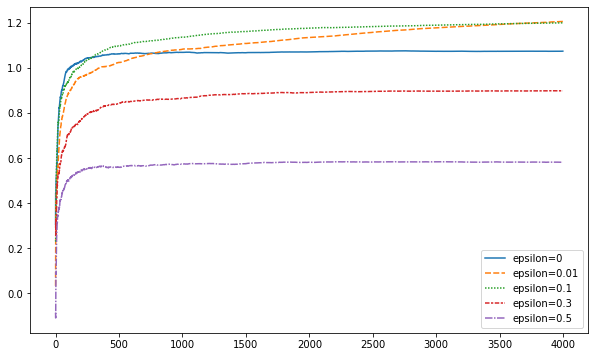

In [55]:
# Epsilon-greedy strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP1.reward_data)

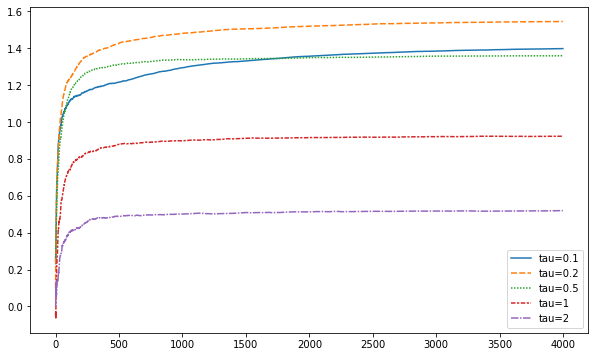

In [78]:
# Softmax strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP2.reward_data)

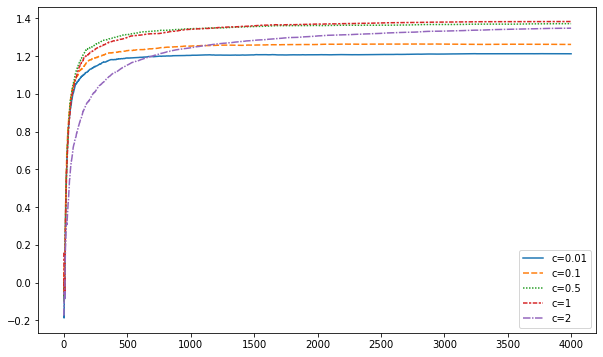

In [57]:
# UCB strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP3.reward_data)

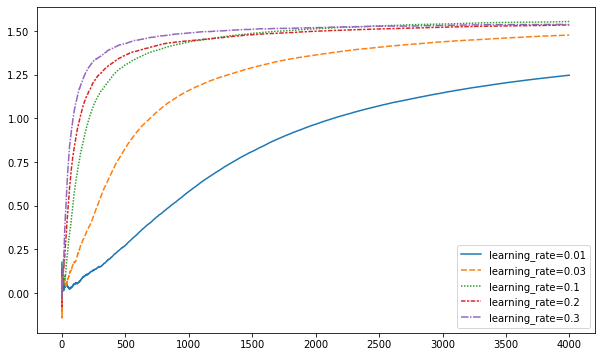

In [58]:
# Gradient strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP4.reward_data)

**1.2 Graphics of each strategy under <font color='brick'>stationary situation</font>**
- Optimal Actions Taken%

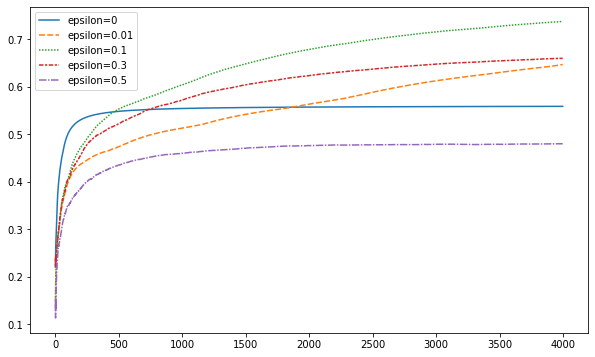

In [59]:
# Epsilon-greedy strategy, optimal actions taken percentage
plt.figure(figsize=(10,6))
sns.lineplot(data = RP1.optimal_taken)

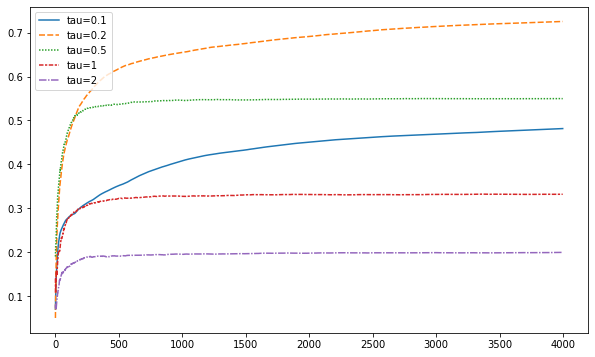

In [79]:
# Softmax strategy, optimal actions taken percentage
plt.figure(figsize=(10,6))
sns.lineplot(data = RP2.optimal_taken)

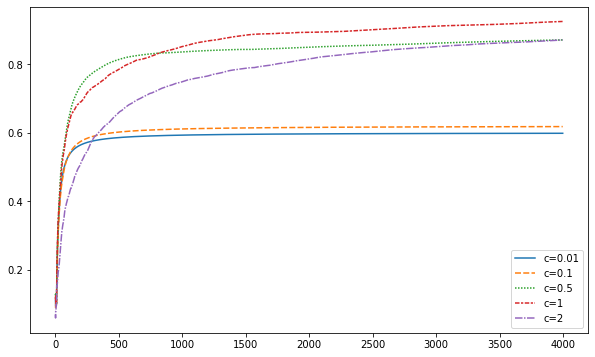

In [61]:
# UCB strategy, optimal actions taken percentage
plt.figure(figsize=(10,6))
sns.lineplot(data = RP3.optimal_taken)

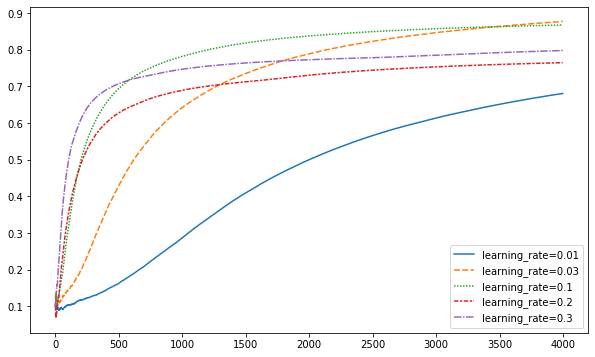

In [62]:
# Gradient strategy, optimal actions taken percentage
plt.figure(figsize=(10,6))
sns.lineplot(data = RP4.optimal_taken)

In [125]:
RP1_N.ReadyPlayer()

# Some action's estimated reward will go to infty under softmax strategy
# RP2_N.ReadyPlayer()

RP3_N.ReadyPlayer()
RP4_N.ReadyPlayer()

**2.1 Graphics of each strategy under <font color='brick'>Nonstationary Situation</font>**
- accumulated reward

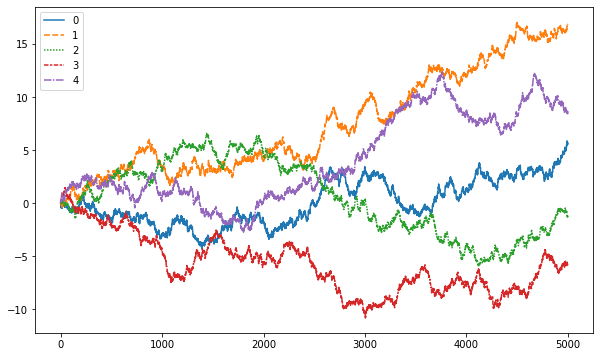

In [126]:
plt.figure(figsize=(10,6))
sns.lineplot(data = RP1_N.nonstationary_track.iloc[:,:5])

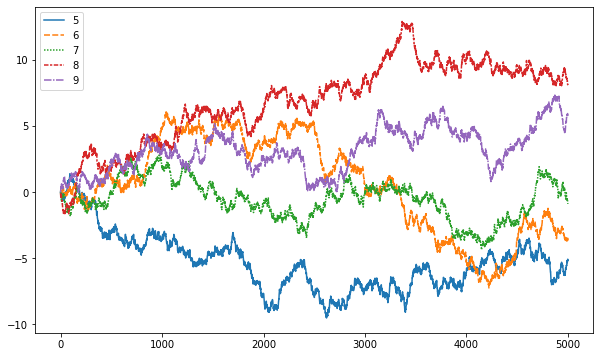

In [127]:
plt.figure(figsize=(10,6))
sns.lineplot(data = RP1_N.nonstationary_track.iloc[:,5:])

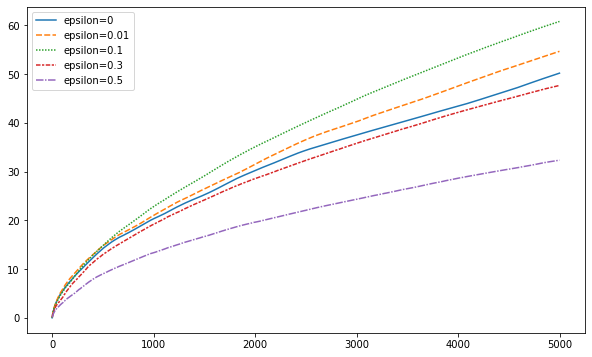

In [128]:
# Epsilon-greedy strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP1_N.reward_data)

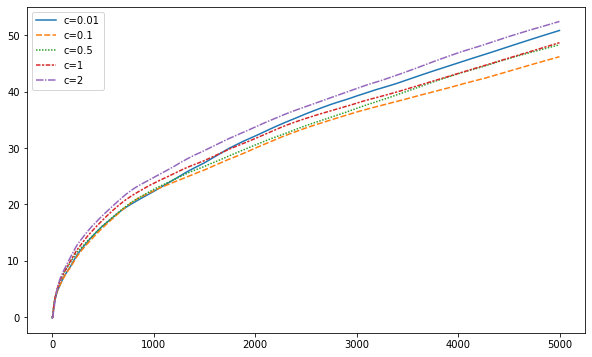

In [129]:
# UCB strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP3_N.reward_data)

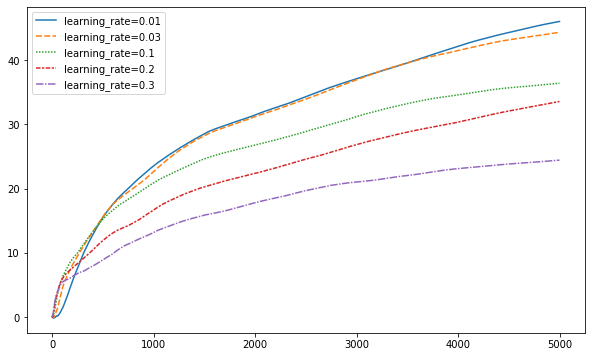

In [130]:
# Gradient strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP4_N.reward_data)

**2.2 Graphics of each strategy under <font color='brick'>Nonstationary Situation</font>**
- Optimal Action Taken%

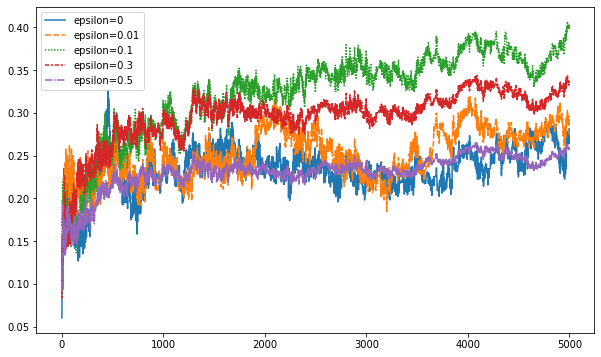

In [131]:
# Epsilon-greedy strategy, total average rewards after 100 games with 5000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP1_N.optimal_taken)

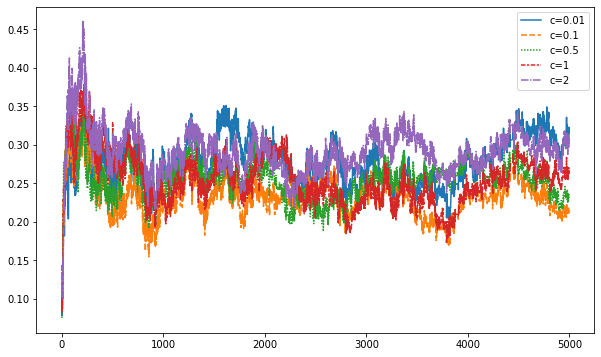

In [132]:
# UCB strategy, total average rewards after 100 games with 5000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP3_N.optimal_taken)

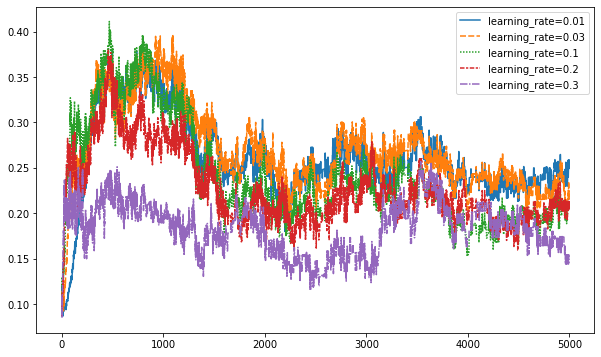

In [133]:
# UCB strategy, total average rewards after 100 games with 5000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP4_N.optimal_taken)

**2.3 Graphics of each strategy under <font color='brick'>Nonstationary Situation</font>**
- Greedy Action Acc Rewards

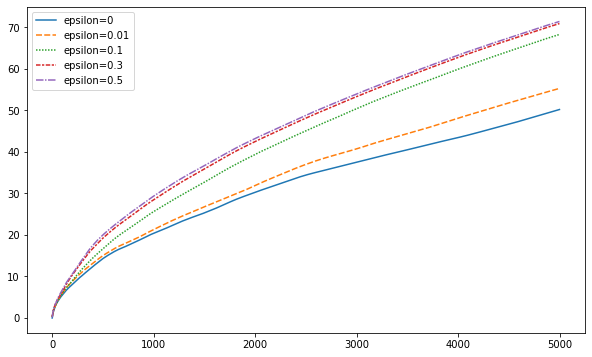

In [134]:
# Epsilon-greedy strategy, total average rewards after 100 games with 5000 playing rounds for each
plt.figure(figsize=(10,6))
sns.lineplot(data = RP1_N.greedy_action)